# Baseline Rydberg Hamiltonian

This notebook establishes a benchmarking benchmark by propagating a large Rydberg Hamiltonian with the current `master` version of QDYN (single-thread). The Hamiltonian is now shifted to be located around 0 GHz which allows for less time steps for the Newton propagation.

In [1]:
import qutip
import numpy as np
import matplotlib.pylab as plt

In [2]:
from src.qdyn.io import read_indexed_matrix
from src.qdyn.model import LevelModel
from src.qdyn.pulse import Pulse
from src.plots import show_spy

In [3]:
%matplotlib inline

In [4]:
V_per_cm = 1.0 / 5.14220624463189208e09

In [5]:
# 1-based indices of the initial and target states
N_INITIAL = 1423
N_TARGET = 2696
# size of Hilbert space
N_HILBERT = N_TARGET

In [6]:
def rydberg_hamiltonian(
    H_drift_file,
    H_sigma_file,
    H_pi_file,
    F_DC,
    Omega_sigma,
):
    """Construct the time-dependent Hamiltonian

    Args:
        H_drift_file (str)
        H_sigma_file (str)
        H_pi_file (str)
        F_DC (float)
        Omega_sig (Pulse)
        exapnd_H_sigma (bool)
    """
    H_drift = qutip.Qobj(
        read_indexed_matrix(
            H_drift_file, shape=(N_HILBERT, N_HILBERT), expand_hermitian=False
        )
    )
    H_sigma = qutip.Qobj(
        read_indexed_matrix(
            H_sigma_file,
            shape=(N_HILBERT, N_HILBERT),
            expand_hermitian=False,
        )
    )
    H_pi = qutip.Qobj(
        read_indexed_matrix(
            H_pi_file, shape=(N_HILBERT, N_HILBERT), expand_hermitian=False
        )
    )
    H_0 = H_drift + F_DC * H_pi
    return [H_0, [H_sigma, Omega_sigma], [H_sigma.dag(), Omega_sigma]]

In [7]:
H = rydberg_hamiltonian(
    'data_shifted/ham_drift.dat',
    'data_shifted/ham_sig.dat',
    'data_shifted/ham_pi.dat',
    F_DC=2.5 * V_per_cm,
    Omega_sigma=Pulse.read('./data_shifted/pulse_sig.dat')
)

In [8]:
psi0 = qutip.ket([N_INITIAL-1], dim=H[0].shape[0])
psi_target = qutip.ket([N_TARGET-1], dim=H[0].shape[0])

In [9]:
def show_spy(m, outfile=None, show_diagonal=False, grid=False):
    fig, ax = plt.subplots()
    ax.spy(m, markersize=1)
    diag_vals = np.linspace(0, m.shape[0], 10)
    if show_diagonal:
        ax.plot(diag_vals, diag_vals, color='black')
    if grid:
        ax.grid()
    if outfile is None:
        plt.show(fig)
    else:
        fig.savefig(outfile)
        plt.close()

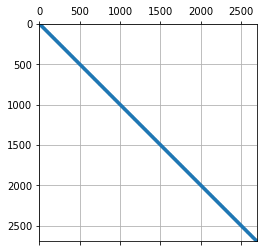

In [10]:
show_spy(H[0].data, show_diagonal=False, grid=True)

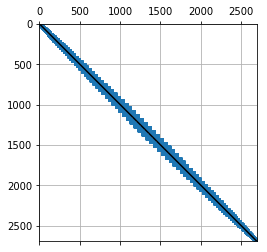

In [11]:
show_spy((H[1][0].data + H[2][0].data), show_diagonal=True, grid=True)

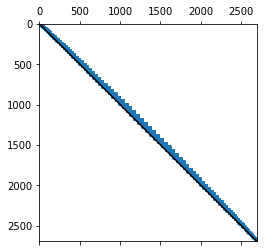

In [12]:
show_spy((H[1][0].data), show_diagonal=True)

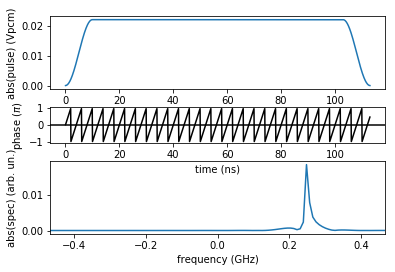

In [13]:
H[1][1].show()

In [14]:
qdyn_model = LevelModel()

In [15]:
qdyn_model.add_ham(H[0], op_unit='au', op_type='pot')

In [16]:
qdyn_model.add_ham(H[1][0], pulse=H[1][1], op_unit='au', op_type='dip')

In [17]:
qdyn_model.add_ham(H[2][0], pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True)

In [18]:
qdyn_model.add_state(psi0, label='initial')

In [19]:
qdyn_model.add_state(psi_target, label='target')

In [20]:
qdyn_model.add_observable(
    qutip.ket2dm(psi0),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='initial',
)
qdyn_model.add_observable(
    qutip.ket2dm(psi_target),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='target',
)

In [21]:
qdyn_model.set_propagation(
    T=H[1][1].T,
    nt=len(H[1][1].states_tgrid),
    time_unit=H[1][1].time_unit,
)

In [22]:
qdyn_model.write_to_runfolder('./rf_baseline')

In [23]:
%%bash
qdyn_prop_traj --version
time qdyn_prop_traj --state-label=initial ./rf_baseline

QDYN 2.0dev revision ac1db5e266da14a23449f2481541fc3018917a66 (rydbergparallel)
  features: check-cheby, check-newton, parallel-ham=sequential, use-mkl=false, parallel-oct, backtraces, no-debug, no-no-ipo
  compiled with ifort on Wed Sep  4 14:09:44 2019 on host bucharim
***** START OF PROGRAM qdyn_prop_traj ******
Wed Sep 4 14:18:30 +0200 2019

*** Read config file ./rf_baseline/config ***
*** Done reading config file ***
*** Initializing system ***
  *** Initializing grid ***
  No explicit grid found in config file! Initializing grid as one dimensional 1x1 fake grid
    Initializing grid as 1D cartesian grid without mapping
      Number of grid points was set to nr = 1 for dimension dim = 1! Initializing dimension 1 as a 1x1 fake-grid...
  *** Initializing pulses ***
    1 pulses in config file
    Initializing pulse 1
  *** Initializing dynamical generator ***
*** Done with initialization ***

Completed traj 1/1 in proc 1/1
Writing avg in proc 1/1

Wed Sep 4 14:18:52 +0200 2019
****

1

real	0m21.966s
user	0m21.600s
sys	0m0.352s
